In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
html_file_path = 'data/raw/2021-06-02.html'
data = pd.read_html(html_file_path)

# Review data

In [3]:
next_matches_index = 0
standings_indexes = range(1,7)
goalkeepers_index = 7
defenders_index = 8
midfielders_index = 9
forwards_index = 10

In [4]:
# data[next_matches_index]

In [5]:
# data[random.randint(min(standings_indexes), max(standings_indexes))]

In [6]:
# data[random.randint(goalkeepers_index, forwards_index)]

# Data reorganize and pre-process

In [7]:
next_matches_columns_renames = {"תאריך": "date", "שעה": "hour", "קבוצה מארחת": "home_team", "תוצאה": "score", "קבוצה אורחת": "away_team", "סקירה": "review"}
next_matches_df = data[next_matches_index].rename(columns=next_matches_columns_renames)
del next_matches_df['hour']
del next_matches_df['review']
next_matches_df['date'] = pd.to_datetime(next_matches_df['date'], format="%d.%m.%Y")

In [8]:
# next_matches_df

In [9]:
standings_columns_renames = {"קבוצה": "team", "מש’": "MP", "נצ’": "W", "תיקו": "D", "הפסד": "L", "יחס": "GF-GA", "נקודות": "Pts"}
groups_standings = []
for index in standings_indexes:
    new_standing_df = data[index].rename(columns=standings_columns_renames)
    new_standing_df['GF'] = new_standing_df['GF-GA'].apply(lambda x: (x.split('-'))[0]).astype('int')
    new_standing_df['GA'] = new_standing_df['GF-GA'].apply(lambda x: (x.split('-'))[1]).astype('int')
    new_standing_df['GD'] = new_standing_df['GF'] - new_standing_df['GA']
    del new_standing_df['GF-GA']
    groups_standings.append(new_standing_df)

In [10]:
# groups_standings[random.randint(0, len(groups_standings)-1)]

In [11]:
gaolkeepers_columns_renames = {"שוער": "name", "מחיר": "price", "נק’": "points"}
gaolkeepers_df = data[goalkeepers_index].rename(columns=gaolkeepers_columns_renames)
gaolkeepers_df['position'] = 'GK'
del gaolkeepers_df['Unnamed: 3']

defenders_columns_renames = {"הגנה": "name", "מחיר": "price", "נק’": "points"}
defenders_df = data[defenders_index].rename(columns=defenders_columns_renames)
del defenders_df['Unnamed: 3']
defenders_df['position'] = 'D'

midfielders_columns_renames = {"קישור": "name", "מחיר": "price", "נק’": "points"}
midfielders_df = data[midfielders_index].rename(columns=midfielders_columns_renames)
del midfielders_df['Unnamed: 3']
midfielders_df['position'] = 'M'

forwards_columns_renames = {"התקפה": "name", "מחיר": "price", "נק’": "points"}
forwards_df = data[forwards_index].rename(columns=forwards_columns_renames)
del forwards_df['Unnamed: 3']
forwards_df['position'] = 'FW'

In [12]:
players_df = pd.concat([gaolkeepers_df, defenders_df, midfielders_df, forwards_df], ignore_index=True)
players_df['team'] = players_df['name'].apply(lambda x: ((x.split('('))[1].split(")"))[0])
players_df['name'] = players_df['name'].apply(lambda x: ((x.split('('))[0])[:-1])
players_df['price'] = players_df['price'].apply(lambda x: (x.split('.'))[0]).astype('int')

In [13]:
# players_df

# Generate random* lineup
*with constraints on formation, budget, maximum players allowed from the same team, minimal player price.

In [14]:
def get_random_lineup(players_df, formation=[4,3,3], budget=100, budget_delta=1, max_same_team=2, min_player_price=4):
    
    if sum(formation) != 10:
        print("Error: Illegal formation. Formation must sum up to 10 players.")
        return
    if (formation[0] < 3 or formation[0] > 5) or (formation[1] < 3 or formation[1] > 5)  or (formation[2] < 1 or formation[2] > 3): 
        print("Error: Illegal formation. 3 <= Defenders,Midfielders <= 5, 1 <= Forwards <= 3")
        return
    
    players_df = players_df[players_df['price'] >= min_player_price]
    
    used_budegt = 0
    same_team = 0
    while (used_budegt < budget - budget_delta) or (used_budegt > budget) or (same_team > max_same_team):
        lineup_df = pd.concat([players_df[players_df['position'] == 'GK'].sample(),
                               players_df[players_df['position'] == 'D'].sample(formation[0]),
                               players_df[players_df['position'] == 'M'].sample(formation[1]),
                               players_df[players_df['position'] == 'FW'].sample(formation[2])])
        used_budegt = lineup_df['price'].sum()
        same_team = lineup_df['team'].value_counts().max()
    
    print(f'Used budget: {used_budegt}.0M')
    return lineup_df

In [15]:
# lineup_df = get_random_lineup(players_df)
# lineup_df

In [16]:
# lineup_df = get_random_lineup(players_df, formation=[3,4,3], budget=100, budget_delta=2, max_same_team=2, min_player_price=5)
# lineup_df

# Features engineering

## Teams features
1. Average betting odds
2. Average power rankings (pr) - source: The Guardian, FIFA, Reddit and my own.
3. Form (points lost in last 6 matches)
4. Wighted sum (of all features)

In [17]:
teams_file_path = 'data/teams.csv'
teams_df = pd.read_csv(teams_file_path, encoding='utf-8')

In [18]:
teams_df

,name_h,name_e,theguardian_pr,fifa_ranking,reddit1_pr,reddit2_pr,my_pr,bets_odds,form_last6,gfpg,gapg
0,צרפת,France,1,2,1,1,2,4.68,WWWDWW,2.500000,0.600000
1,אנגליה,England,4,3,8,9,1,5.03,WWWWWL,4.625000,0.750000
2,בלגיה,Belgium,3,1,2,6,5,6.20,WDWWWW,4.000000,0.300000
3,ספרד,Spain,10,5,5,3,7,7.87,WWDWDD,3.100000,0.500000
4,גרמניה,Germany,2,8,9,4,3,7.93,DLWWLW,3.750000,0.875000
5,פורטוגל,Portugal,6,4,3,2,10,8.59,WDWWLW,2.750000,0.750000
6,איטליה,Italy,7,6,4,5,4,10.37,WWWWWW,3.700000,0.400000
7,הולנד,Netherlands,16,11,6,7,6,12.26,DWWLWW,3.000000,0.875000
8,דנמרק,Denmark,8,7,7,10,8,27.05,DWWWLW,2.875000,0.750000
9,קרואטיה,Croatia,18,10,13,8,11,34.27,DWWLLL,2.125000,0.875000


In [19]:
power_rank_columns = ["theguardian_pr", "fifa_ranking", "reddit1_pr", "reddit2_pr", "my_pr"]
teams_df['power_rank_avg'] = teams_df[power_rank_columns].mean(axis=1)
max_points = 18
teams_df['form_points_lost'] = max_points - ( 3 * teams_df['form_last6'].str.count('W') +  teams_df['form_last6'].str.count('D'))

teams_df.drop(power_rank_columns, axis='columns', inplace=True)
teams_df.drop('form_last6', axis='columns', inplace=True)

In [20]:
# teams_df

### Normalize features
* MimMax normalize (to [0,1])

In [21]:
minimum = teams_df['bets_odds'].min()
maximum = teams_df['bets_odds'].max()
teams_df['bets_odds'] = (teams_df['bets_odds'] - minimum)/(maximum - minimum)

minimum = teams_df['power_rank_avg'].min()
maximum = teams_df['power_rank_avg'].max()
teams_df['power_rank_avg'] = (teams_df['power_rank_avg'] - minimum)/(maximum - minimum)

minimum = teams_df['form_points_lost'].min()
maximum = teams_df['form_points_lost'].max()
teams_df['form_points_lost'] = (teams_df['form_points_lost'] - minimum)/(maximum - minimum)

In [22]:
teams_df

,name_h,name_e,bets_odds,gfpg,gapg,power_rank_avg,form_points_lost
0,צרפת,France,0.000000,2.500000,0.600000,0.000000,0.153846
1,אנגליה,England,0.000716,4.625000,0.750000,0.162162,0.230769
2,בלגיה,Belgium,0.003110,4.000000,0.300000,0.090090,0.153846
3,ספרד,Spain,0.006528,3.100000,0.500000,0.207207,0.461538
4,גרמניה,Germany,0.006650,3.750000,0.875000,0.171171,0.615385
5,פורטוגל,Portugal,0.008001,2.750000,0.750000,0.162162,0.384615
6,איטליה,Italy,0.011643,3.700000,0.400000,0.171171,0.000000
7,הולנד,Netherlands,0.015511,3.000000,0.875000,0.351351,0.384615
8,דנמרק,Denmark,0.045775,2.875000,0.750000,0.297297,0.384615
9,קרואטיה,Croatia,0.060550,2.125000,0.875000,0.477477,0.846154


### Make features "higher is better" and calculate wighted sum feature

In [23]:
teams_df['bets_odds'] = 1 - teams_df['bets_odds']
teams_df['power_rank_avg'] = 1 - teams_df['power_rank_avg']
teams_df['form_points_lost'] = 1 - teams_df['form_points_lost']

In [24]:
w_bets_odds = 0.5
w_power_rank_avg = 0.3
w_form_points_lost = 0.2
w_power = 1.4
teams_df['wighted_sum'] = (w_bets_odds * teams_df['bets_odds']) + (w_power_rank_avg * teams_df['power_rank_avg']) + (w_form_points_lost * teams_df['form_points_lost'])
teams_df['wighted_sum'] = np.power(teams_df['wighted_sum'], w_power)

### Tweek GFpG and GApG (the tournament itsel is harder than qualifiers)

In [25]:
teams_df['gfpg'] = 0.8 * teams_df['gfpg']
teams_df['gapg'] = 1.2 * teams_df['gapg']

In [26]:
teams_df.describe()

,bets_odds,gfpg,gapg,power_rank_avg,form_points_lost,wighted_sum
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.758128,1.905556,0.989167,0.500000,0.461538,0.541921
std,0.306170,0.750427,0.408964,0.300420,0.290489,0.288458
min,0.000000,1.000000,0.360000,0.000000,0.000000,0.027573
25%,0.721771,1.295000,0.690000,0.274775,0.211538,0.390561
50%,0.852432,1.770000,0.930000,0.495495,0.500000,0.585617
75%,0.989267,2.325000,1.110000,0.801802,0.634615,0.766842
max,1.000000,3.700000,2.000000,1.000000,1.000000,0.957190


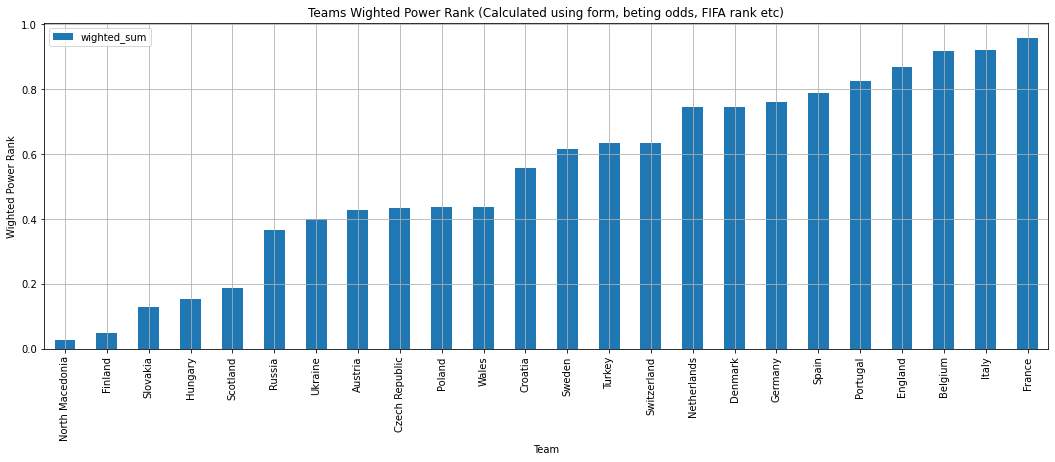

In [27]:
teams_df.sort_values("wighted_sum", inplace=True)
teams_df.plot(x="name_e", y=["wighted_sum"], kind="bar", figsize=(18,6));
plt.grid();
plt.xticks(rotation=90);
plt.title('Teams Wighted Power Rank (Calculated using form, beting odds, FIFA rank etc)');
plt.xlabel('Team');
plt.ylabel('Wighted Power Rank');

## Players features
1. Accumulated points
2. Team power rank
3. Team GF
4. Team GA
5. Team GD
6. Opponent power rank diffenrence
7. Opponent GF
8. Opponent GA
9. Opponent GD
*more features later

### Get Team power ranking, (current) GF, GA, and GFpG, GApG (from qualifiers)

In [28]:
teams_wights_df = teams_df[['name_h', 'wighted_sum', 'gfpg', 'gapg']].set_index('name_h')
players_df['team_pr'] = players_df.apply(lambda row: teams_wights_df.loc[row['team']].get('wighted_sum'), axis=1)
players_df['team_gfpg'] = players_df.apply(lambda row: teams_wights_df.loc[row['team']].get('gfpg'), axis=1)
players_df['team_gapg'] = players_df.apply(lambda row: teams_wights_df.loc[row['team']].get('gapg'), axis=1)
players_df

,name,price,points,position,team,team_pr,team_gfpg,team_gapg
0,הוגו לוריס,10,0,GK,צרפת,0.957190,2.000000,0.72
1,אונאי סימון,9,0,GK,ספרד,0.786374,2.480000,0.60
2,טיבו קורטואה,9,0,GK,בלגיה,0.917906,3.200000,0.36
3,מנואל נוייר,9,0,GK,גרמניה,0.760331,3.000000,1.05
4,ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,2.960000,0.48
...,...,...,...,...,...,...,...,...
613,מילאן ריסטובסקי,4,0,FW,צפון מקדוניה,0.027573,1.000000,1.40
614,מרקוס פורס,4,0,FW,פינלנד,0.046977,1.280000,1.20
615,ריאן כריסטי,4,0,FW,סקוטלנד,0.187972,1.133333,2.00
616,ולאטקו סטויאנובסקי,3,0,FW,צפון מקדוניה,0.027573,1.000000,1.40


In [29]:
total_standings_df = pd.concat(groups_standings)
total_standings_df = total_standings_df[['team', 'GF', 'GA']].set_index('team')
players_df['team_GF'] = players_df.apply(lambda row: total_standings_df.loc[row['team']].get('GF'), axis=1)
players_df['team_GA'] = players_df.apply(lambda row: total_standings_df.loc[row['team']].get('GA'), axis=1)

### Get Opponent power ranking, GF, GA

In [30]:
opponents1_df = next_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = next_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_df = pd.concat([opponents1_df, opponents2_df])
opponents_df['opponent'] = opponents_df.fillna('').sum(axis=1)
opponents_df.drop(columns=['home_team', 'away_team'], inplace=True)
players_df['opponent'] = players_df.apply(lambda row: opponents_df.loc[row['team']], axis=1)

In [31]:
players_df['opponent_pr'] = players_df.apply(lambda row: teams_wights_df.loc[row['opponent']].get('wighted_sum'), axis=1)
players_df['opponent_gfpg'] = players_df.apply(lambda row: teams_wights_df.loc[row['opponent']].get('gfpg'), axis=1)
players_df['opponent_gapg'] = players_df.apply(lambda row: teams_wights_df.loc[row['opponent']].get('gapg'), axis=1)

In [32]:
players_df['opponent_GF'] = players_df.apply(lambda row: total_standings_df.loc[row['opponent']].get('GF'), axis=1)
players_df['opponent_GA'] = players_df.apply(lambda row: total_standings_df.loc[row['opponent']].get('GA'), axis=1)

In [33]:
players_df

,name,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent,opponent_pr,opponent_gfpg,opponent_gapg,opponent_GF,opponent_GA
0,הוגו לוריס,10,0,GK,צרפת,0.957190,2.000000,0.72,0,0,גרמניה,0.760331,3.00,1.05,0,0
1,אונאי סימון,9,0,GK,ספרד,0.786374,2.480000,0.60,0,0,שבדיה,0.615554,1.84,1.08,0,0
2,טיבו קורטואה,9,0,GK,בלגיה,0.917906,3.200000,0.36,0,0,רוסיה,0.366186,2.00,0.96,0,0
3,מנואל נוייר,9,0,GK,גרמניה,0.760331,3.000000,1.05,0,0,צרפת,0.957190,2.00,0.72,0,0
4,ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,2.960000,0.48,0,0,טורקיה,0.633793,1.44,0.36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,מילאן ריסטובסקי,4,0,FW,צפון מקדוניה,0.027573,1.000000,1.40,0,0,אוסטריה,0.427429,1.52,1.08,0,0
614,מרקוס פורס,4,0,FW,פינלנד,0.046977,1.280000,1.20,0,0,דנמרק,0.745812,2.30,0.90,0,0
615,ריאן כריסטי,4,0,FW,סקוטלנד,0.187972,1.133333,2.00,0,0,צ`כיה,0.432834,1.30,1.65,0,0
616,ולאטקו סטויאנובסקי,3,0,FW,צפון מקדוניה,0.027573,1.000000,1.40,0,0,אוסטריה,0.427429,1.52,1.08,0,0


## More players features
* extracted from statistics of World Cup Qualifiers and Nations League metches (whoscored.com)
1. Appearances
2. Minuts played
3. Goals
4. Assists
5. Shots per Game (SpG)
6. Rating - overall performance score
7. Appearances % out of maximum number of appearances
8. Minuts played % out of maximum number Minuts played
9. Goals % out of all team's goals
10. Assists % out of all team's assists
11. Goals and Assists (GnA) % out of all team's goals and assists.

In [34]:
teams_names = teams_df['name_e'].values
teams_stats_df_dict = {}
for team in teams_names:
#     print(team)
    team_file_path = f'data/raw/teams/{team}/r1.html'
    team_data = pd.read_html(team_file_path)
    team_df = (team_data[1])[['Player.1', 'Apps', 'Mins', 'Goals', 'Assists', 'SpG', 'Rating']]
    team_df.rename(columns={"Player.1": "Player"}, inplace=True)
    team_df = team_df.replace('-', 0)
    team_df['Player'] = team_df['Player'].apply(lambda x: (x.split(',')[0])[:-3])
    team_df['Apps'] = team_df['Apps'].apply(lambda x: (x.split('(')[0]))
    teams_stats_df_dict[f'{team}'] = team_df

In [35]:
teams_stats_df_dict2 = {}
for team in teams_names:
#     print(team)
    team_file_path = f'data/raw/teams/{team}/r11.html'
    team_data = pd.read_html(team_file_path)
    team_df = (team_data[1])[['Player.1', 'Apps', 'Mins', 'Goals', 'Assists', 'SpG', 'Rating']]
    team_df.rename(columns={"Player.1": "Player"}, inplace=True)
    team_df = team_df.replace('-', 0)
    team_df['Player'] = team_df['Player'].apply(lambda x: (x.split(',')[0])[:-3])
    team_df['Apps'] = team_df['Apps'].apply(lambda x: (x.split('(')[0]))
    teams_stats_df_dict2[f'{team}'] = team_df

In [36]:
convert_dict = {'Player': str,
                'Apps': int,
                'Mins': int,
                'Goals': int,
                'Assists': int,
                'SpG': float,
                'Rating': float}

teams_stats_merged_df_dict = {}
for team in teams_names:
    df = teams_stats_df_dict[team].append(teams_stats_df_dict2[team])
    df = df.astype(convert_dict)
    grouped = df.groupby('Player').agg({'Apps': 'sum',
                                    'Mins': 'sum',
                                    'Goals': 'sum',
                                    'Assists': 'sum',
                                    'SpG': 'mean',
                                    'Rating': 'mean'})
    apps_max = grouped['Apps'].max()
    mins_max = grouped['Mins'].max()
    goals_sum = grouped['Goals'].sum()
    assists_sum = grouped['Assists'].sum()
    grouped['Apps%'] = grouped['Apps'] / apps_max
    grouped['Mins%'] = grouped['Mins'] / mins_max
    grouped['Goals%'] = grouped['Goals'] / goals_sum
    grouped['Assists%'] = grouped['Assists'] / assists_sum
    grouped['GnA%'] = (grouped['Goals'] + grouped['Assists']) / (goals_sum + assists_sum)
    teams_stats_merged_df_dict[team] = grouped


In [37]:
all_players_stats_df = pd.concat(list(teams_stats_merged_df_dict.values()))

In [38]:
players_names_df = pd.read_csv('data/players.csv', encoding='utf-8-sig')
players_names_df.drop('team', axis=1, inplace=True)

In [39]:
players_df.set_index('name', inplace=True)

In [40]:
all_players_stats_df = all_players_stats_df.merge(players_names_df, left_on=all_players_stats_df.index, right_on='name_e')
all_players_stats_df.rename(columns={'name_h': 'name'},inplace=True)
all_players_stats_df.set_index('name', inplace=True)

In [41]:
players_df = players_df.merge(all_players_stats_df, left_index=True, right_index=True)

In [42]:
players_df.to_csv('players_stats.csv', encoding='utf-8-sig')
players_df

,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent,...,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e,is_penalty_taker,is_starter
name,,,,,,,,,,,,,,,,,,,,,
הוגו לוריס,10,0,GK,צרפת,0.957190,2.000000,0.72,0,0,גרמניה,...,0.00,6.750,1.000000,1.000000,0.000000,0.0,0.000000,Hugo Lloris,0,0
אונאי סימון,9,0,GK,ספרד,0.786374,2.480000,0.60,0,0,שבדיה,...,0.00,6.120,0.714286,0.702028,0.000000,0.0,0.000000,Unai Simón,0,0
טיבו קורטואה,9,0,GK,בלגיה,0.917906,3.200000,0.36,0,0,רוסיה,...,0.00,6.385,0.444444,0.444444,0.000000,0.0,0.000000,Thibaut Courtois,0,1
מנואל נוייר,9,0,GK,גרמניה,0.760331,3.000000,1.05,0,0,צרפת,...,0.00,6.505,0.750000,0.736698,0.000000,0.0,0.000000,Manuel Neuer,0,0
ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,2.960000,0.48,0,0,טורקיה,...,0.00,6.865,1.000000,1.000000,0.000000,0.0,0.000000,Gianluigi Donnarumma,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
חליל דרויסוגלו,4,0,FW,טורקיה,0.633793,1.440000,0.36,0,0,איטליה,...,0.00,6.030,0.000000,0.005900,0.000000,0.0,0.000000,Halil Akbunar,0,0
מרקוס פורס,4,0,FW,פינלנד,0.046977,1.280000,1.20,0,0,דנמרק,...,0.50,6.040,0.000000,0.079320,0.000000,0.0,0.000000,Marcus Forss,0,0
ריאן כריסטי,4,0,FW,סקוטלנד,0.187972,1.133333,2.00,0,0,צ`כיה,...,2.15,7.380,0.625000,0.684722,0.166667,0.1,0.136364,Ryan Christie,1,0


In [43]:
players_df.describe()

,price,points,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent_pr,opponent_gfpg,opponent_gapg,...,Assists,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,is_penalty_taker,is_starter
count,514.000000,514.0,514.000000,514.000000,514.000000,514.0,514.0,514.000000,514.000000,514.000000,...,514.00000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000
mean,6.202335,0.0,0.549961,1.920752,1.002899,0.0,0.0,0.528597,1.877536,0.998093,...,0.42607,0.827043,6.751946,0.462657,0.462129,0.041368,0.039474,0.040626,0.046693,0.219844
std,2.225564,0.0,0.285706,0.757448,0.404356,0.0,0.0,0.284865,0.741077,0.414717,...,0.79434,0.952046,0.473670,0.299160,0.285134,0.072177,0.074683,0.058014,0.211185,0.414545
min,3.000000,0.0,0.027573,1.000000,0.360000,0.0,0.0,0.027573,1.000000,0.360000,...,0.00000,0.000000,5.100000,0.000000,0.001389,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.0,0.374311,1.280000,0.720000,0.0,0.0,0.366186,1.280000,0.630000,...,0.00000,0.025000,6.441250,0.222222,0.222262,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,0.0,0.615554,1.840000,0.960000,0.0,0.0,0.555679,1.700000,0.900000,...,0.00000,0.550000,6.732500,0.444444,0.444444,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,0.0,0.786374,2.400000,1.200000,0.0,0.0,0.760331,2.300000,1.200000,...,1.00000,1.037500,7.035000,0.714286,0.683158,0.066667,0.076923,0.062500,0.000000,0.000000
max,15.000000,0.0,0.957190,3.700000,2.000000,0.0,0.0,0.957190,3.700000,2.000000,...,5.00000,6.150000,10.000000,1.000000,1.000000,0.500000,0.500000,0.352941,1.000000,1.000000


## Example (random) lineup from filtered pool

In [44]:
lineup_df = get_random_lineup(players_df, formation=[3,4,3], budget=100, budget_delta=1, max_same_team=2, min_player_price=5)
lineup_df

Used budget: 99.0M


,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent,...,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e,is_penalty_taker,is_starter
name,,,,,,,,,,,,,,,,,,,,,
מנואל נוייר,9,0,GK,גרמניה,0.760331,3.00,1.05,0,0,צרפת,...,0.00,6.505,0.750000,0.736698,0.000000,0.000000,0.000000,Manuel Neuer,0,0
ג'ייסון דנאייר,7,0,D,בלגיה,0.917906,3.20,0.36,0,0,רוסיה,...,0.10,6.735,0.888889,0.890123,0.035714,0.000000,0.020833,Jason Denayer,0,0
פביאן שר,7,0,D,שווייץ,0.634722,1.90,0.90,0,0,וויילס,...,0.00,5.230,0.285714,0.285714,0.000000,0.000000,0.000000,Fabian Schär,0,1
בנז'מין פבאר,9,0,D,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,0.60,7.335,0.555556,0.555556,0.071429,0.000000,0.045455,Benjamin Pavard,0,0
לאנדרו טרוסארד,6,0,M,בלגיה,0.917906,3.20,0.36,0,0,רוסיה,...,0.90,6.800,0.222222,0.241975,0.071429,0.000000,0.041667,Leandro Trossard,0,0
כריסטיאן אריקסן,9,0,M,דנמרק,0.745812,2.30,0.90,0,0,פינלנד,...,2.05,7.055,0.888889,0.956919,0.200000,0.000000,0.129032,Christian Eriksen,1,1
דומניקו ברארדי,10,0,M,איטליה,0.920884,2.96,0.48,0,0,טורקיה,...,1.65,7.605,0.222222,0.234568,0.230769,0.000000,0.130435,Domenico Berardi,0,0
ג'ורג'יניו ווינאלדום,8,0,M,הולנד,0.744417,2.40,1.05,0,0,אוקראינה,...,3.05,7.305,1.000000,0.954321,0.222222,0.071429,0.156250,Georginio Wijnaldum,0,1
אלבארו מוראטה,11,0,FW,ספרד,0.786374,2.48,0.60,0,0,שבדיה,...,2.60,7.200,0.571429,0.555382,0.105263,0.000000,0.057143,Álvaro Morata,1,0


## Filter players pool

In [45]:
players_filtered_df = pd.DataFrame(columns=players_df.columns)

### filter goalkeepers
* only 1st GK of each team (by minutes %)

In [46]:
min_minuts = 0.65
is_opener_gk= (players_df['position'] == 'GK') & (players_df['Mins%'] > min_minuts)

filtered = players_df[is_opener_gk]
players_filtered_df = pd.concat([players_filtered_df, filtered])

### filter defenders
* openers defenders
* high rated (higher than average)
* scorred or assisted at least once

In [47]:
min_minuts = 0.65
is_opner_defender = (players_df['position'] == 'D') & (players_df['Mins%'] > min_minuts)
rate_th = players_df['Rating'].mean()
is_high_rated = players_df['Rating'] > rate_th
scored_or_assisted = (players_df['GnA%'] > 0)

filtered = players_df[is_opner_defender & is_high_rated & scored_or_assisted]
players_filtered_df = pd.concat([players_filtered_df, filtered])

### filter midfielders
* openers midfielders
* high rated (higher than average)
* scorred or assisted at least once

In [48]:
min_appearances = 0.55
is_opner_midfielder = (players_df['position'] == 'M') & (players_df['Apps%'] > min_appearances)
rate_th = players_df['Rating'].mean()
is_high_rated = players_df['Rating'] > rate_th
scored_or_assisted = (players_df['GnA%'] > 0)

filtered = players_df[is_opner_midfielder & is_high_rated & scored_or_assisted]
players_filtered_df = pd.concat([players_filtered_df, filtered])

### filter forwards
* openers forwards
* high rated (higher than average)
* scorred or assisted in at least 10% of the team goals

In [49]:
min_appearances = 0.60
is_opner_forward = (players_df['position'] == 'FW') & (players_df['Apps%'] > min_appearances)
rate_th = players_df['Rating'].mean()
is_high_rated = players_df['Rating'] > rate_th
scored_or_assisted = (players_df['GnA%'] > 0.1)

filtered = players_df[is_opner_forward & is_high_rated & scored_or_assisted]
players_filtered_df = pd.concat([players_filtered_df, filtered])

In [50]:
players_filtered_df.to_csv('players_filtered_stats.csv', encoding='utf-8-sig')
players_filtered_df

,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent,...,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e,is_penalty_taker,is_starter
הוגו לוריס,10,0,GK,צרפת,0.957190,2.000000,0.72,0,0,גרמניה,...,0.00,6.750,1.000000,1.000000,0.000000,0.000000,0.000000,Hugo Lloris,0,0
אונאי סימון,9,0,GK,ספרד,0.786374,2.480000,0.60,0,0,שבדיה,...,0.00,6.120,0.714286,0.702028,0.000000,0.000000,0.000000,Unai Simón,0,0
מנואל נוייר,9,0,GK,גרמניה,0.760331,3.000000,1.05,0,0,צרפת,...,0.00,6.505,0.750000,0.736698,0.000000,0.000000,0.000000,Manuel Neuer,0,0
ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,2.960000,0.48,0,0,טורקיה,...,0.00,6.865,1.000000,1.000000,0.000000,0.000000,0.000000,Gianluigi Donnarumma,0,0
ג'ורדן פיקפורד,8,0,GK,אנגליה,0.869361,3.700000,0.90,0,0,קרואטיה,...,0.00,6.350,0.750000,0.764873,0.000000,0.000000,0.000000,Jordan Pickford,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
טימו פוקי,6,0,FW,פינלנד,0.046977,1.280000,1.20,0,0,דנמרק,...,3.60,7.480,1.000000,1.000000,0.500000,0.142857,0.352941,Teemu Pukki,1,1
קנאן קארמאן,6,0,FW,טורקיה,0.633793,1.440000,0.36,0,0,איטליה,...,1.40,6.895,1.000000,1.000000,0.187500,0.111111,0.160000,Kenan Karaman,0,1
אדם סאלאי,5,0,FW,הונגריה,0.151662,1.040000,1.56,0,0,פורטוגל,...,2.25,6.925,0.750000,0.711111,0.117647,0.090909,0.107143,Ádám Szalai,1,0
נמניה ניקוליץ',5,0,FW,הונגריה,0.151662,1.040000,1.56,0,0,פורטוגל,...,0.75,6.975,0.625000,0.563889,0.117647,0.272727,0.178571,Nemanja Nikolic,0,0


## Create lineup using filterd players pool

In [51]:
lineup_df = get_random_lineup(players_filtered_df, formation=[3,4,3], budget=100, budget_delta=1, max_same_team=2, min_player_price=5)
lineup_df

Used budget: 100.0M


,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent,...,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e,is_penalty_taker,is_starter
ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,2.96,0.48,0,0,טורקיה,...,0.00,6.865,1.000000,1.000000,0.000000,0.000000,0.000000,Gianluigi Donnarumma,0,0
צ'לאר סויונג'ו,6,0,D,טורקיה,0.633793,1.44,0.36,0,0,איטליה,...,0.40,6.825,0.625000,0.663717,0.062500,0.000000,0.040000,Çaglar Söyüncü,0,1
טובי אלדרווירלד,8,0,D,בלגיה,0.917906,3.20,0.36,0,0,רוסיה,...,0.75,7.105,1.000000,1.000000,0.000000,0.050000,0.020833,Toby Alderweireld,0,1
ריקרדו רודריגס,7,0,D,שווייץ,0.634722,1.90,0.90,0,0,וויילס,...,0.70,7.125,1.000000,0.958730,0.000000,0.125000,0.055556,Ricardo Rodríguez,1,1
לירוי סאנה,12,0,M,גרמניה,0.760331,3.00,1.05,0,0,צרפת,...,1.15,7.035,0.875000,0.702592,0.066667,0.083333,0.074074,Leroy Sané,0,0
אדריין ראביו,7,0,M,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,1.00,7.025,0.777778,0.781481,0.000000,0.125000,0.045455,Adrien Rabiot,0,0
רודרי,6,0,M,ספרד,0.786374,2.48,0.60,0,0,שבדיה,...,0.65,6.885,0.571429,0.544462,0.052632,0.000000,0.028571,Rodri,0,0
לורנצו אינסינייה,11,0,M,איטליה,0.920884,2.96,0.48,0,0,טורקיה,...,2.90,7.495,0.666667,0.658025,0.000000,0.500000,0.217391,Lorenzo Insigne,0,1
סרג' גנאברי,13,0,FW,גרמניה,0.760331,3.00,1.05,0,0,צרפת,...,2.75,7.265,0.875000,0.854025,0.133333,0.166667,0.148148,Serge Gnabry,0,0
רומלו לוקאקו,14,0,FW,בלגיה,0.917906,3.20,0.36,0,0,רוסיה,...,3.15,7.540,0.777778,0.777778,0.250000,0.050000,0.166667,Romelu Lukaku,1,1


## (let's try..) More aggresive filters

In [52]:
players_aggresivly_filtered_df = pd.DataFrame(columns=players_df.columns)

more stable and high rated goalkeepers

In [53]:
min_minuts = 0.70
is_opener_gk= (players_df['position'] == 'GK') & (players_df['Mins%'] > min_minuts)
rate_th = 6.3
is_high_rated = players_df['Rating'] > rate_th

filtered = players_df[is_opener_gk]
players_aggresivly_filtered_df = pd.concat([players_aggresivly_filtered_df, filtered])

defenders that scored or assisted at least twice

In [54]:
min_minuts = 0.65
is_opner_defender = (players_df['position'] == 'D') & (players_df['Mins%'] > min_minuts)
rate_th = players_df['Rating'].mean()
is_high_rated = players_df['Rating'] > rate_th
scored_or_assisted = (players_df['Goals'] + players_df['Assists'] >= 2)

filtered = players_df[is_opner_defender & is_high_rated & scored_or_assisted]
players_aggresivly_filtered_df = pd.concat([players_aggresivly_filtered_df, filtered])

more stable midfielders that were involved in at least 10% of their team goals and assists ans take at least 1 shot per game.

In [55]:
min_appearances = 0.60
is_opner_midfielder = (players_df['position'] == 'M') & (players_df['Apps%'] > min_appearances)
rate_th = players_df['Rating'].mean()
is_high_rated = players_df['Rating'] > rate_th
scored_or_assisted = (players_df['GnA%'] > 0.1)
spg = (players_df['SpG'] > 1)

filtered = players_df[is_opner_midfielder & is_high_rated & scored_or_assisted & spg]
players_aggresivly_filtered_df = pd.concat([players_aggresivly_filtered_df, filtered])

more stable forwards that were involved in at least 15% of their team goals and assists

In [56]:
min_appearances = 0.65
is_opner_forward = (players_df['position'] == 'FW') & (players_df['Apps%'] > min_appearances)
rate_th = players_df['Rating'].mean()
is_high_rated = players_df['Rating'] > rate_th
scored_or_assisted = (players_df['GnA%'] > 0.15)

filtered = players_df[is_opner_forward & is_high_rated & scored_or_assisted]
players_aggresivly_filtered_df = pd.concat([players_aggresivly_filtered_df, filtered])

In [57]:
players_aggresivly_filtered_df.to_csv('players_aggresivly_filtered_stats.csv', encoding='utf-8-sig')
players_aggresivly_filtered_df

,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent,...,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e,is_penalty_taker,is_starter
הוגו לוריס,10,0,GK,צרפת,0.957190,2.000000,0.72,0,0,גרמניה,...,0.00,6.750,1.000000,1.000000,0.000000,0.000000,0.000000,Hugo Lloris,0,0
אונאי סימון,9,0,GK,ספרד,0.786374,2.480000,0.60,0,0,שבדיה,...,0.00,6.120,0.714286,0.702028,0.000000,0.000000,0.000000,Unai Simón,0,0
מנואל נוייר,9,0,GK,גרמניה,0.760331,3.000000,1.05,0,0,צרפת,...,0.00,6.505,0.750000,0.736698,0.000000,0.000000,0.000000,Manuel Neuer,0,0
ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,2.960000,0.48,0,0,טורקיה,...,0.00,6.865,1.000000,1.000000,0.000000,0.000000,0.000000,Gianluigi Donnarumma,0,0
ג'ורדן פיקפורד,8,0,GK,אנגליה,0.869361,3.700000,0.90,0,0,קרואטיה,...,0.00,6.350,0.750000,0.764873,0.000000,0.000000,0.000000,Jordan Pickford,0,0
דומיניק ליבאקוביץ',7,0,GK,קרואטיה,0.555679,1.700000,1.05,0,0,אנגליה,...,0.00,6.390,1.000000,1.000000,0.000000,0.000000,0.000000,Dominik Livakovic,0,0
ווייצ'ך שצ'סני,7,0,GK,פולין,0.436064,1.440000,0.60,0,0,סלובקיה,...,0.00,6.450,0.750000,0.718085,0.000000,0.000000,0.000000,Wojciech Szczesny,0,0
יאן זומר,7,0,GK,שווייץ,0.634722,1.900000,0.90,0,0,וויילס,...,0.00,6.475,1.000000,1.000000,0.000000,0.000000,0.000000,Yann Sommer,0,1
קספר שמייכל,7,0,GK,דנמרק,0.745812,2.300000,0.90,0,0,פינלנד,...,0.00,6.650,1.000000,1.000000,0.000000,0.000000,0.000000,Kasper Schmeichel,0,1
אנטון שונין,6,0,GK,רוסיה,0.366186,2.000000,0.96,0,0,בלגיה,...,0.00,6.655,0.875000,0.886076,0.000000,0.000000,0.000000,Anton Shunin,0,1


## Create lineup using aggresivly filterd players pool

In [58]:
lineup_df = get_random_lineup(players_aggresivly_filtered_df, formation=[3,4,3], budget=100, budget_delta=1, max_same_team=2, min_player_price=5)
lineup_df

Used budget: 100.0M


,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent,...,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e,is_penalty_taker,is_starter
קספר שמייכל,7,0,GK,דנמרק,0.745812,2.30,0.90,0,0,פינלנד,...,0.00,6.650,1.000000,1.000000,0.000000,0.000000,0.000000,Kasper Schmeichel,0,1
ז'ואאו קאנסלו,8,0,D,פורטוגל,0.823428,2.20,0.90,0,0,הונגריה,...,1.25,7.285,0.777778,0.780247,0.058824,0.142857,0.096774,João Cancelo,0,0
אזגיאן אליוסקי,5,0,D,צפון מקדוניה,0.027573,1.00,1.40,0,0,אוסטריה,...,0.65,7.050,0.777778,0.799472,0.117647,0.100000,0.111111,Ezgjan Alioski,1,1
רובן דיאס,8,0,D,פורטוגל,0.823428,2.20,0.90,0,0,הונגריה,...,0.90,7.050,1.000000,1.000000,0.117647,0.000000,0.064516,Rúben Dias,0,0
אנטואן גרייזמן,13,0,M,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,1.85,7.490,1.000000,0.938272,0.285714,0.125000,0.227273,Antoine Griezmann,0,0
כריסטיאן אריקסן,9,0,M,דנמרק,0.745812,2.30,0.90,0,0,פינלנד,...,2.05,7.055,0.888889,0.956919,0.200000,0.000000,0.129032,Christian Eriksen,1,1
אילקאי גונדואן,9,0,M,גרמניה,0.760331,3.00,1.05,0,0,צרפת,...,1.10,7.265,0.875000,0.837653,0.200000,0.000000,0.111111,Ilkay Gündogan,1,0
ניקולה ולאשיץ',9,0,M,קרואטיה,0.555679,1.70,1.05,0,0,אנגליה,...,2.00,7.040,0.888889,0.872840,0.166667,0.125000,0.150000,Nikola Vlasic,0,0
ממפיס דפאיי,12,0,FW,הולנד,0.744417,2.40,1.05,0,0,אוקראינה,...,6.15,8.260,0.888889,0.874074,0.222222,0.214286,0.218750,Memphis Depay,1,1
רומלו לוקאקו,14,0,FW,בלגיה,0.917906,3.20,0.36,0,0,רוסיה,...,3.15,7.540,0.777778,0.777778,0.250000,0.050000,0.166667,Romelu Lukaku,1,1


## Predict matches outcome

In [59]:
matches_df = opponents_df.merge(teams_df, left_index=True, right_on='name_h').set_index('name_h')
matches_df.drop(columns=['name_e', 'bets_odds', 'power_rank_avg', 'form_points_lost'], inplace=True)
matches_df.rename(columns={'wighted_sum': 'pr'}, inplace=True)
matches_df['opponent_pr'] = matches_df.apply(lambda row: matches_df.loc[row['opponent']].get('pr'), axis=1)
matches_df['opponent_gfpg'] = matches_df.apply(lambda row: matches_df.loc[row['opponent']].get('gfpg'), axis=1)
matches_df['opponent_gapg'] = matches_df.apply(lambda row: matches_df.loc[row['opponent']].get('gapg'), axis=1)
matches_df['pr_diff'] = matches_df['pr'] - matches_df['opponent_pr']
matches_df.drop(columns=['pr', 'opponent_pr'], inplace=True)
# matches_df

In [60]:
pr_diff_wight = 1.3
def calc_GF(x):
    numenator = x.gfpg + x.opponent_gapg
    denuminator = 2 - pr_diff_wight * x.pr_diff
    return numenator / denuminator

def calc_GA(x):
    numenator = x.gapg + x.opponent_gfpg
    denuminator = 2 + pr_diff_wight * x.pr_diff
    return numenator / denuminator

In [61]:
matches_df['pred_GF'] = matches_df.apply(lambda row: calc_GF(row), axis=1)
matches_df['pred_GA'] = matches_df.apply(lambda row: calc_GA(row), axis=1)
matches_df['pred_score'] = matches_df.apply(lambda row: (np.floor(row.pred_GF).astype(int), np.floor(row.pred_GA).astype(int)), axis=1)
matches_df

,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score
name_h,,,,,,,,,
טורקיה,איטליה,1.440000,0.36,2.960000,0.48,-0.287090,0.809028,2.040838,"(0, 2)"
וויילס,שווייץ,1.000000,0.90,1.900000,0.90,-0.197141,0.842093,1.605766,"(0, 1)"
דנמרק,פינלנד,2.300000,0.90,1.280000,1.20,0.698835,3.206553,0.749531,"(3, 0)"
בלגיה,רוסיה,3.200000,0.36,2.000000,0.96,0.551720,3.242998,0.868530,"(3, 0)"
אנגליה,קרואטיה,3.700000,0.90,1.700000,1.05,0.313682,2.983268,1.079830,"(2, 1)"
אוסטריה,צפון מקדוניה,1.520000,1.08,1.000000,1.40,0.399857,1.972724,0.825458,"(1, 0)"
הולנד,אוקראינה,2.400000,1.05,1.700000,0.60,0.345731,1.934798,1.122701,"(1, 1)"
סקוטלנד,צ`כיה,1.133333,2.00,1.300000,1.65,-0.244862,1.200582,1.962324,"(1, 1)"
פולין,סלובקיה,1.440000,0.60,1.200000,1.44,0.308373,1.800997,0.749723,"(1, 0)"


In [62]:
def calc_is_starter(x):
    if x['Apps%'] > 0.6 or x['Mins%'] > 0.6:
        return 1
    else:
        return 0

In [63]:
new_players_df = players_df.merge(matches_df, left_on='team', right_index=True)
new_players_df['is_starter'] = new_players_df.apply(lambda row: calc_is_starter(row), axis=1)
new_players_df

,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent_x,...,is_starter,opponent_y,gfpg,gapg,opponent_gfpg_y,opponent_gapg_y,pr_diff,pred_GF,pred_GA,pred_score
name,,,,,,,,,,,,,,,,,,,,,
הוגו לוריס,10,0,GK,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,1,גרמניה,2.00,0.72,3.0,1.05,0.196859,1.748769,1.648997,"(1, 1)"
רפאל וראן,10,0,D,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,1,גרמניה,2.00,0.72,3.0,1.05,0.196859,1.748769,1.648997,"(1, 1)"
בנז'מין פבאר,9,0,D,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,0,גרמניה,2.00,0.72,3.0,1.05,0.196859,1.748769,1.648997,"(1, 1)"
לוקאס הרננדז,9,0,D,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,1,גרמניה,2.00,0.72,3.0,1.05,0.196859,1.748769,1.648997,"(1, 1)"
פרסנל קמפמבה,9,0,D,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,1,גרמניה,2.00,0.72,3.0,1.05,0.196859,1.748769,1.648997,"(1, 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
דויד סיגר,3,0,M,הונגריה,0.151662,1.04,1.56,0,0,פורטוגל,...,1,פורטוגל,1.04,1.56,2.2,0.90,-0.671767,0.675183,3.337170,"(0, 3)"
דניאל גזדג,3,0,M,הונגריה,0.151662,1.04,1.56,0,0,פורטוגל,...,0,פורטוגל,1.04,1.56,2.2,0.90,-0.671767,0.675183,3.337170,"(0, 3)"
רולנד ורגה,3,0,M,הונגריה,0.151662,1.04,1.56,0,0,פורטוגל,...,0,פורטוגל,1.04,1.56,2.2,0.90,-0.671767,0.675183,3.337170,"(0, 3)"


In [64]:
penalty_per_match = 0.4
score_penalty_odds = 0.85

penalty_taker_bonus = penalty_per_match * score_penalty_odds
penalty_taker_penalty = 4 * penalty_per_match * (1 - score_penalty_odds)

def goals_against_bonus(goals_num):
    if goals_num == 0:
        return 4
    else:
        return 3 - goals_num

def calc_gk_score(x):
    return x.is_starter * (2 + goals_against_bonus(np.floor(x.pred_GA)))

def calc_d_score(x):
    return x.is_starter * (2 + goals_against_bonus(np.floor(x.pred_GA)) + 3*x['Assists%']*x.pred_GF + 6*x['Goals%']*x.pred_GF + x.is_penalty_taker*(6*penalty_taker_bonus - penalty_taker_penalty))

def calc_m_score(x):
    return x.is_starter * (2 + 3*x['Assists%']*x.pred_GF + 5*x['Goals%']*x.pred_GF + x.is_penalty_taker*(5*penalty_taker_bonus - penalty_taker_penalty))

def calc_fw_score(x):
    return x.is_starter * (2 + 3*x['Assists%']*x.pred_GF + 4*x['Goals%']*x.pred_GF + x.is_penalty_taker*(4*penalty_taker_bonus - penalty_taker_penalty))

In [65]:
gk_predicted_scores = new_players_df[new_players_df['position'] == 'GK']
gk_predicted_scores['pred_points'] = gk_predicted_scores.apply(lambda row: calc_gk_score(row), axis=1)

d_predicted_scores = new_players_df[new_players_df['position'] == 'D']
d_predicted_scores['pred_points'] = new_players_df.apply(lambda row: calc_d_score(row), axis=1)

m_predicted_scores = new_players_df[new_players_df['position'] == 'M']
m_predicted_scores['pred_points'] = new_players_df.apply(lambda row: calc_m_score(row), axis=1)

fw_predicted_scores = new_players_df[new_players_df['position'] == 'FW']
fw_predicted_scores['pred_points'] = new_players_df.apply(lambda row: calc_fw_score(row), axis=1)

players_predicted_score_df = pd.concat([gk_predicted_scores, d_predicted_scores, m_predicted_scores, fw_predicted_scores])
players_predicted_score_df

,price,points,position,team,team_pr,team_gfpg,team_gapg,team_GF,team_GA,opponent_x,...,opponent_y,gfpg,gapg,opponent_gfpg_y,opponent_gapg_y,pr_diff,pred_GF,pred_GA,pred_score,pred_points
name,,,,,,,,,,,,,,,,,,,,,
הוגו לוריס,10,0,GK,צרפת,0.957190,2.00,0.72,0,0,גרמניה,...,גרמניה,2.00,0.72,3.00,1.05,0.196859,1.748769,1.648997,"(1, 1)",4.000000
אונאי סימון,9,0,GK,ספרד,0.786374,2.48,0.60,0,0,שבדיה,...,שבדיה,2.48,0.60,1.84,1.08,0.170820,2.002324,1.098077,"(2, 1)",4.000000
דויד דה חאה,6,0,GK,ספרד,0.786374,2.48,0.60,0,0,שבדיה,...,שבדיה,2.48,0.60,1.84,1.08,0.170820,2.002324,1.098077,"(2, 1)",0.000000
טיבו קורטואה,9,0,GK,בלגיה,0.917906,3.20,0.36,0,0,רוסיה,...,רוסיה,3.20,0.36,2.00,0.96,0.551720,3.242998,0.868530,"(3, 0)",0.000000
סיימון מיניולה,4,0,GK,בלגיה,0.917906,3.20,0.36,0,0,רוסיה,...,רוסיה,3.20,0.36,2.00,0.96,0.551720,3.242998,0.868530,"(3, 0)",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
איבן טריקובסקי,5,0,FW,צפון מקדוניה,0.027573,1.00,1.40,0,0,אוסטריה,...,אוסטריה,1.00,1.40,1.52,1.08,-0.399857,0.825458,1.972724,"(0, 1)",0.000000
ולאטקו סטויאנובסקי,3,0,FW,צפון מקדוניה,0.027573,1.00,1.40,0,0,אוסטריה,...,אוסטריה,1.00,1.40,1.52,1.08,-0.399857,0.825458,1.972724,"(0, 1)",0.000000
קרסטה ולקובסקי,3,0,FW,צפון מקדוניה,0.027573,1.00,1.40,0,0,אוסטריה,...,אוסטריה,1.00,1.40,1.52,1.08,-0.399857,0.825458,1.972724,"(0, 1)",0.000000


In [66]:
players_predicted_score_df.drop(columns=['team_pr', 'team_gfpg', 'team_gapg', 'team_GF', 'team_GA', 'opponent_pr', 'opponent_gfpg_x', 'opponent_gapg_x', 'opponent_GF', 'opponent_GA', 'Apps', 'Mins', 'Goals', 'Assists', 'gfpg', 'gapg', 'opponent_gfpg_y', 'opponent_gapg_y', 'opponent_y'], inplace=True)

In [67]:
cols = ['SpG', 'Rating', 'Apps%', 'Mins%', 'Goals%', 'Assists%', 'GnA%', 'pr_diff', 'pred_GF', 'pred_GA', 'pred_points']
players_predicted_score_df[cols] = players_predicted_score_df[cols].round(3)

In [68]:
players_predicted_score_df

,price,points,position,team,opponent_x,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e,is_penalty_taker,is_starter,pr_diff,pred_GF,pred_GA,pred_score,pred_points
name,,,,,,,,,,,,,,,,,,,,
הוגו לוריס,10,0,GK,צרפת,גרמניה,0.00,6.750,1.000,1.000,0.000,0.000,0.000,Hugo Lloris,0,1,0.197,1.749,1.649,"(1, 1)",4.000
אונאי סימון,9,0,GK,ספרד,שבדיה,0.00,6.120,0.714,0.702,0.000,0.000,0.000,Unai Simón,0,1,0.171,2.002,1.098,"(2, 1)",4.000
דויד דה חאה,6,0,GK,ספרד,שבדיה,0.00,6.920,0.571,0.562,0.000,0.000,0.000,David de Gea,0,0,0.171,2.002,1.098,"(2, 1)",0.000
טיבו קורטואה,9,0,GK,בלגיה,רוסיה,0.00,6.385,0.444,0.444,0.000,0.000,0.000,Thibaut Courtois,0,0,0.552,3.243,0.869,"(3, 0)",0.000
סיימון מיניולה,4,0,GK,בלגיה,רוסיה,0.00,6.565,0.444,0.488,0.000,0.000,0.000,Simon Mignolet,0,0,0.552,3.243,0.869,"(3, 0)",0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
איבן טריקובסקי,5,0,FW,צפון מקדוניה,אוסטריה,2.00,6.450,0.444,0.427,0.059,0.000,0.037,Ivan Trichkovski,0,0,-0.400,0.825,1.973,"(0, 1)",0.000
ולאטקו סטויאנובסקי,3,0,FW,צפון מקדוניה,אוסטריה,1.00,6.385,0.111,0.203,0.059,0.000,0.037,Vlatko Stojanovski,0,0,-0.400,0.825,1.973,"(0, 1)",0.000
קרסטה ולקובסקי,3,0,FW,צפון מקדוניה,אוסטריה,0.50,6.140,0.000,0.032,0.000,0.000,0.000,Krste Velkoski,0,0,-0.400,0.825,1.973,"(0, 1)",0.000


In [69]:
players_predicted_score_df.sort_values('pred_points').tail(10)

,price,points,position,team,opponent_x,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e,is_penalty_taker,is_starter,pr_diff,pred_GF,pred_GA,pred_score,pred_points
name,,,,,,,,,,,,,,,,,,,,
ג'ייסון דנאייר,7,0,D,בלגיה,רוסיה,0.10,6.735,0.889,0.890,0.036,0.000,0.021,Jason Denayer,0,1,0.552,3.243,0.869,"(3, 0)",6.695
רוברט לבנדובסקי,13,0,FW,פולין,סלובקיה,2.75,7.605,0.750,0.570,0.385,0.154,0.269,Robert Lewandowski,1,1,0.308,1.801,0.750,"(1, 0)",6.722
קמיל גליק,7,0,D,פולין,סלובקיה,0.65,6.805,1.000,1.000,0.077,0.000,0.038,Kamil Glik,0,1,0.308,1.801,0.750,"(1, 0)",6.831
אלכסנדר דרגוביץ',6,0,D,אוסטריה,צפון מקדוניה,0.35,6.670,0.667,0.686,0.071,0.000,0.040,Aleksandar Dragovic,0,1,0.400,1.973,0.825,"(1, 0)",6.845
רומלו לוקאקו,14,0,FW,בלגיה,רוסיה,3.15,7.540,0.778,0.778,0.250,0.050,0.167,Romelu Lukaku,1,1,0.552,3.243,0.869,"(3, 0)",6.849
תומא מונייה,8,0,D,בלגיה,רוסיה,0.40,7.305,0.667,0.667,0.000,0.100,0.042,Thomas Meunier,0,1,0.552,3.243,0.869,"(3, 0)",6.973
שטפן ליינר,6,0,D,אוסטריה,צפון מקדוניה,0.90,6.900,1.000,1.000,0.000,0.273,0.120,Stefan Lainer,0,1,0.400,1.973,0.825,"(1, 0)",7.614
רובן דיאס,8,0,D,פורטוגל,הונגריה,0.90,7.050,1.000,1.000,0.118,0.000,0.065,Rúben Dias,0,1,0.672,3.337,0.675,"(3, 0)",8.356
ריקרדו רודריגס,7,0,D,שווייץ,וויילס,0.70,7.125,1.000,0.959,0.000,0.125,0.056,Ricardo Rodríguez,1,1,0.197,1.606,0.842,"(1, 0)",8.402


In [70]:
# ppm = Points per Million
players_predicted_score_df['ppm'] = players_predicted_score_df['pred_points'] / players_predicted_score_df['price']
players_predicted_score_df.sort_values('ppm').tail(10)

,price,points,position,team,opponent_x,SpG,Rating,Apps%,Mins%,Goals%,...,GnA%,name_e,is_penalty_taker,is_starter,pr_diff,pred_GF,pred_GA,pred_score,pred_points,ppm
name,,,,,,,,,,,,,,,,,,,,,
ז'ואאו קאנסלו,8,0,D,פורטוגל,הונגריה,1.25,7.285,0.778,0.780,0.059,...,0.097,João Cancelo,0,1,0.672,3.337,0.675,"(3, 0)",8.608,1.076000
מרטין הינטרגר,6,0,D,אוסטריה,צפון מקדוניה,0.50,6.800,0.667,0.569,0.000,...,0.040,Martin Hinteregger,0,1,0.400,1.973,0.825,"(1, 0)",6.538,1.089667
אנדראס אולמר,6,0,D,אוסטריה,צפון מקדוניה,0.40,6.450,0.667,0.653,0.000,...,0.040,Andreas Ulmer,0,1,0.400,1.973,0.825,"(1, 0)",6.538,1.089667
אלכסנדר דרגוביץ',6,0,D,אוסטריה,צפון מקדוניה,0.35,6.670,0.667,0.686,0.071,...,0.040,Aleksandar Dragovic,0,1,0.400,1.973,0.825,"(1, 0)",6.845,1.140833
סטפן אודונל,4,0,D,סקוטלנד,צ`כיה,0.90,6.770,0.625,0.601,0.000,...,0.091,Stephen O'Donnell,0,1,-0.245,1.201,1.962,"(1, 1)",4.720,1.180000
ריקרדו רודריגס,7,0,D,שווייץ,וויילס,0.70,7.125,1.000,0.959,0.000,...,0.056,Ricardo Rodríguez,1,1,0.197,1.606,0.842,"(1, 0)",8.402,1.200286
שטפן ליינר,6,0,D,אוסטריה,צפון מקדוניה,0.90,6.900,1.000,1.000,0.000,...,0.120,Stefan Lainer,0,1,0.400,1.973,0.825,"(1, 0)",7.614,1.269000
אזגיאן אליוסקי,5,0,D,צפון מקדוניה,אוסטריה,0.65,7.050,0.778,0.799,0.118,...,0.111,Ezgjan Alioski,1,1,-0.400,0.825,1.973,"(0, 1)",6.630,1.326000
דמיאן סיסקובסקי,3,0,GK,צפון מקדוניה,אוסטריה,0.00,6.680,0.556,0.619,0.000,...,0.000,Damjan Siskovski,0,1,-0.400,0.825,1.973,"(0, 1)",4.000,1.333333
